In [4]:
import os
import sys
sys.path.append("/home/ubuntu/anaconda3/lib/python3.6/site-packages")
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate as intp
import sys
import time
from matplotlib import animation, rc
from matplotlib.pyplot import figure
import hdf5storage as h5mat
import h5py as h5
import sklearn.model_selection
import pydot
from matplotlib.pyplot import figure
import math

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [5]:
# Checking the devices available for use in AWS
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1553205714870970291
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 244514816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15973308435282499495
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [6]:
# directory info
model_directory = '/home/ubuntu/CS230_project/velocitynn/data/layers/models/'
model_file = '600x200x10000_flat2.mat'
model_path = model_directory+model_file
shot_directory = '/home/ubuntu/CS230_project/velocitynn/data/layers/shots/'
shot_file = '600x200x10000_flat2_1shot.mat'
shot_path=shot_directory+shot_file
filepath=os.getcwd()


In [7]:
# Reading all the shot data
dout = h5.File(shot_path,'r')

# Reading all the velocity models
dout1 = h5.File(model_path,'r')

depth_sample = 10
vel_top = 1500
time_max = 0.8
time_sample = 2e-3
time_interp = np.arange(depth_sample/vel_top, time_max,time_sample)

num_shots = 1000
shot_shape_offset,shot_shape_time  = dout['shot_model_1'].shape
shot_data =  np.zeros((shot_shape_offset,shot_shape_time,num_shots)) #offset, time, samples
vel_rms_data = np.zeros((time_interp.shape[0],num_shots))

for i in range(num_shots):
    shot_data[:,:,i] = dout['shot_model_'+str(i)]
    vp_dummy = dout1['vp'+str(i)]
    vp_dummy = np.transpose(vp_dummy[:,:])
    vp_trace = vp_dummy[:,int(vp_dummy.shape[1]/2)]
    time_diff = depth_sample/vp_trace
    time = np.cumsum(time_diff)
    vp = intp.interp1d(time, vp_trace)(time_interp)
    vel_rms_data[:,i] = np.sqrt(np.cumsum(vp**2)/np.arange(1,vp.shape[0]+1,1))
    
del dout, dout1, vp_dummy, vp_trace, time, vp

print('n_x:',shot_data.shape)
print('n_y:', vel_rms_data.shape)

n_x: (599, 433, 1000)
n_y: (397, 1000)


In [8]:
# Import keras modules for CNN

from keras import layers, initializers, optimizers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
# from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')


Using TensorFlow backend.


In [9]:
# Normalize input and output data
shot_data_normalize = (shot_data - np.min(shot_data, axis =(0,1)))/(np.max(shot_data, axis =(0,1))-np.min(shot_data, axis =(0,1)))
vel_rms_data_normalize = (vel_rms_data - np.min(vel_rms_data, axis=0))/(np.max(vel_rms_data, axis=0) - np.min(vel_rms_data, axis=0))

# Reshape
vel_rms_data_normalize = vel_rms_data_normalize.transpose()
shot_data_normalize = np.swapaxes(shot_data_normalize.transpose(),1,2 )

# Split data into train and test set
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(shot_data_normalize,vel_rms_data_normalize, test_size=0.2, random_state=1)

# X_test, X_val, Y_test, Y_val = sklearn.model_selection.train_test_split(X_test, Y_test, test_size=0.5, random_state=1)

# Add 4th dimension of number of channels=1 to the input data
X_train = np.expand_dims(X_train, axis=3)
# X_val = np.expand_dims(X_val, axis=3)
X_test = np.expand_dims(X_test, axis=3)

print ("number of training examples = " + str(X_train.shape[0]))
# print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
# print ("X_val shape: " + str(X_val.shape))
# print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 800
number of test examples = 200
X_train shape: (800, 599, 433, 1)
Y_train shape: (800, 397)
X_test shape: (200, 599, 433, 1)
Y_test shape: (200, 397)


In [13]:
# Building neural network in Keras 
given_seed = 3 # For repeatibility

def velocitynet(input_shape):
    """
    Implementation of the VelocityNet.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    

    # Define the input placeholder as a tensor with shape input_shape. Input = input shot gather 
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    #X = ZeroPadding2D((3, 3))(X_input)
    X = X_input

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(16, (14, 14), strides=(2, 2), name='conv0', 
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), strides=(2,2),name='max_pool0')(X)
    
    # Adding Dropout
    X = Dropout(0.3)(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (10, 10), strides=(2, 2), name='conv1',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=3, name='bn1')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), strides=(2,2),name='max_pool1')(X)
    
    # Adding Dropout
    X = Dropout(0.3)(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(64, (8, 8), strides=(2, 2), name='conv2',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=3, name='bn2')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((8, 8), strides=(4,4),name='max_pool2')(X)
    
    # Adding Dropout
    X = Dropout(0.3)(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    
    X = Dense(397, activation='sigmoid', name='fc')(X)
    X = Activation('relu')(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='velModel')

    return model
    ### END CODE HERE ###

In [14]:
# Create the model
velModel = velocitynet(X_train.shape[1:])


In [12]:
# Summary and plot of the model

velModel.summary()


plot_model(velModel)
SVG(model_to_dot(velModel).create(prog='dot', format='svg'))
plot_model(velModel, to_file='./Figures/model_plot_08Nov_Vishal.png', show_shapes=True, show_layer_names=True)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 599, 433, 1)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 293, 210, 16)      3152      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 293, 210, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 293, 210, 16)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 146, 105, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 146, 105, 16)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 69, 48, 32)        51232     
__________

In [10]:
# Learning rate scheduler
from keras.callbacks import LearningRateScheduler
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.1
    epochs_drop = 250.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [50]:
# Compile the model with optimization algorithm, loss function
# from keras.utils import multi_gpu_model
# velModel = multi_gpu_model(velModel, gpus=1)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

velModel.compile(loss='mean_squared_error', metrics=['accuracy', 'mse'], optimizer = adam)

In [51]:
# Start the training
# Using learning rate scheduler
# lrate = LearningRateScheduler(step_decay)
# callbacks_list = [lrate]
# history = velModel.fit(X_train, Y_train, validation_split=0.1, epochs=500, batch_size=32, callbacks=callbacks_list)

history = velModel.fit(X_train, Y_train, validation_split=0.1, epochs=500, batch_size=32)

Train on 720 samples, validate on 80 samples
Epoch 1/500
720/720 [==============================] - 6s 9ms/step - loss: 0.0712 - acc: 0.0069 - mean_squared_error: 0.0712 - val_loss: 0.0183 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0183
Epoch 2/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0167 - acc: 0.0139 - mean_squared_error: 0.0167 - val_loss: 0.0107 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0107
Epoch 3/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0133 - acc: 0.0236 - mean_squared_error: 0.0133 - val_loss: 0.0078 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0078
Epoch 4/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0120 - acc: 0.0236 - mean_squared_error: 0.0120 - val_loss: 0.0069 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0069
Epoch 5/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0113 - acc: 0.0292 - mean_squared_error: 0.0113 - val_loss: 0.0065 - val_acc: 0.00

Epoch 84/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0021 - acc: 0.4250 - mean_squared_error: 0.0021 - val_loss: 0.0057 - val_acc: 0.9375 - val_mean_squared_error: 0.0057
Epoch 85/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0021 - acc: 0.3681 - mean_squared_error: 0.0021 - val_loss: 0.0072 - val_acc: 0.9375 - val_mean_squared_error: 0.0072
Epoch 86/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0020 - acc: 0.4528 - mean_squared_error: 0.0020 - val_loss: 0.0067 - val_acc: 0.9375 - val_mean_squared_error: 0.0067
Epoch 87/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0020 - acc: 0.3819 - mean_squared_error: 0.0020 - val_loss: 0.0046 - val_acc: 0.9375 - val_mean_squared_error: 0.0046
Epoch 88/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0020 - acc: 0.4083 - mean_squared_error: 0.0020 - val_loss: 0.0053 - val_acc: 0.9375 - val_mean_squared_error: 0.0053
Epoch 89/500
720/720

Epoch 126/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0014 - acc: 0.4111 - mean_squared_error: 0.0014 - val_loss: 0.0104 - val_acc: 0.7875 - val_mean_squared_error: 0.0104
Epoch 127/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0015 - acc: 0.4625 - mean_squared_error: 0.0015 - val_loss: 0.0112 - val_acc: 0.8125 - val_mean_squared_error: 0.0112
Epoch 128/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0014 - acc: 0.4819 - mean_squared_error: 0.0014 - val_loss: 0.0086 - val_acc: 0.8250 - val_mean_squared_error: 0.0086
Epoch 129/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0014 - acc: 0.5319 - mean_squared_error: 0.0014 - val_loss: 0.0067 - val_acc: 0.9000 - val_mean_squared_error: 0.0067
Epoch 130/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0014 - acc: 0.5444 - mean_squared_error: 0.0014 - val_loss: 0.0076 - val_acc: 0.9000 - val_mean_squared_error: 0.0076
Epoch 131/500
7

720/720 [==============================] - 4s 6ms/step - loss: 9.8875e-04 - acc: 0.8042 - mean_squared_error: 9.8875e-04 - val_loss: 0.0142 - val_acc: 0.8375 - val_mean_squared_error: 0.0142
Epoch 209/500
720/720 [==============================] - 4s 6ms/step - loss: 9.6619e-04 - acc: 0.8000 - mean_squared_error: 9.6619e-04 - val_loss: 0.0129 - val_acc: 0.9000 - val_mean_squared_error: 0.0129
Epoch 210/500
720/720 [==============================] - 4s 6ms/step - loss: 9.3797e-04 - acc: 0.7569 - mean_squared_error: 9.3797e-04 - val_loss: 0.0064 - val_acc: 0.9375 - val_mean_squared_error: 0.0064
Epoch 211/500
720/720 [==============================] - 4s 6ms/step - loss: 9.7080e-04 - acc: 0.7597 - mean_squared_error: 9.7080e-04 - val_loss: 0.0064 - val_acc: 0.9250 - val_mean_squared_error: 0.0064
Epoch 212/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0010 - acc: 0.8028 - mean_squared_error: 0.0010 - val_loss: 0.0096 - val_acc: 0.9250 - val_mean_squared_error: 0.00

720/720 [==============================] - 4s 6ms/step - loss: 8.0948e-04 - acc: 0.8417 - mean_squared_error: 8.0948e-04 - val_loss: 0.0075 - val_acc: 0.9375 - val_mean_squared_error: 0.0075
Epoch 289/500
720/720 [==============================] - 4s 6ms/step - loss: 8.0215e-04 - acc: 0.8333 - mean_squared_error: 8.0215e-04 - val_loss: 0.0096 - val_acc: 0.9375 - val_mean_squared_error: 0.0096
Epoch 290/500
720/720 [==============================] - 4s 6ms/step - loss: 8.0778e-04 - acc: 0.8639 - mean_squared_error: 8.0778e-04 - val_loss: 0.0124 - val_acc: 0.9375 - val_mean_squared_error: 0.0124
Epoch 291/500
720/720 [==============================] - 4s 6ms/step - loss: 7.9696e-04 - acc: 0.8806 - mean_squared_error: 7.9696e-04 - val_loss: 0.0152 - val_acc: 0.9375 - val_mean_squared_error: 0.0152
Epoch 292/500
720/720 [==============================] - 4s 6ms/step - loss: 8.6279e-04 - acc: 0.8931 - mean_squared_error: 8.6279e-04 - val_loss: 0.0111 - val_acc: 0.9375 - val_mean_squared_err

720/720 [==============================] - 4s 6ms/step - loss: 7.4655e-04 - acc: 0.9014 - mean_squared_error: 7.4655e-04 - val_loss: 0.0027 - val_acc: 0.9250 - val_mean_squared_error: 0.0027
Epoch 329/500
720/720 [==============================] - 4s 6ms/step - loss: 7.4526e-04 - acc: 0.9181 - mean_squared_error: 7.4526e-04 - val_loss: 0.0022 - val_acc: 0.9375 - val_mean_squared_error: 0.0022
Epoch 330/500
720/720 [==============================] - 4s 6ms/step - loss: 7.9357e-04 - acc: 0.9097 - mean_squared_error: 7.9357e-04 - val_loss: 0.0021 - val_acc: 0.9375 - val_mean_squared_error: 0.0021
Epoch 331/500
720/720 [==============================] - 4s 6ms/step - loss: 7.5821e-04 - acc: 0.8958 - mean_squared_error: 7.5821e-04 - val_loss: 0.0031 - val_acc: 0.9375 - val_mean_squared_error: 0.0031
Epoch 332/500
720/720 [==============================] - 4s 6ms/step - loss: 7.8390e-04 - acc: 0.8944 - mean_squared_error: 7.8390e-04 - val_loss: 0.0032 - val_acc: 0.9375 - val_mean_squared_err

720/720 [==============================] - 4s 6ms/step - loss: 7.2032e-04 - acc: 0.9028 - mean_squared_error: 7.2032e-04 - val_loss: 0.0095 - val_acc: 0.9375 - val_mean_squared_error: 0.0095
Epoch 369/500
720/720 [==============================] - 4s 6ms/step - loss: 7.3301e-04 - acc: 0.9194 - mean_squared_error: 7.3301e-04 - val_loss: 0.0102 - val_acc: 0.9375 - val_mean_squared_error: 0.0102
Epoch 370/500
720/720 [==============================] - 4s 6ms/step - loss: 7.3890e-04 - acc: 0.9125 - mean_squared_error: 7.3890e-04 - val_loss: 0.0079 - val_acc: 0.9375 - val_mean_squared_error: 0.0079
Epoch 371/500
720/720 [==============================] - 4s 6ms/step - loss: 6.9199e-04 - acc: 0.9278 - mean_squared_error: 6.9199e-04 - val_loss: 0.0155 - val_acc: 0.3625 - val_mean_squared_error: 0.0155
Epoch 372/500
720/720 [==============================] - 4s 6ms/step - loss: 7.1739e-04 - acc: 0.9264 - mean_squared_error: 7.1739e-04 - val_loss: 0.0185 - val_acc: 0.1500 - val_mean_squared_err

720/720 [==============================] - 4s 6ms/step - loss: 6.9944e-04 - acc: 0.9403 - mean_squared_error: 6.9944e-04 - val_loss: 0.0072 - val_acc: 0.9375 - val_mean_squared_error: 0.0072
Epoch 409/500
720/720 [==============================] - 4s 6ms/step - loss: 6.9969e-04 - acc: 0.9611 - mean_squared_error: 6.9969e-04 - val_loss: 0.0064 - val_acc: 0.9375 - val_mean_squared_error: 0.0064
Epoch 410/500
720/720 [==============================] - 4s 6ms/step - loss: 6.8301e-04 - acc: 0.9625 - mean_squared_error: 6.8301e-04 - val_loss: 0.0039 - val_acc: 0.9375 - val_mean_squared_error: 0.0039
Epoch 411/500
720/720 [==============================] - 4s 6ms/step - loss: 6.7626e-04 - acc: 0.9556 - mean_squared_error: 6.7626e-04 - val_loss: 0.0051 - val_acc: 0.9375 - val_mean_squared_error: 0.0051
Epoch 412/500
720/720 [==============================] - 4s 6ms/step - loss: 6.5465e-04 - acc: 0.9514 - mean_squared_error: 6.5465e-04 - val_loss: 0.0043 - val_acc: 0.9375 - val_mean_squared_err

720/720 [==============================] - 4s 6ms/step - loss: 6.2716e-04 - acc: 0.9611 - mean_squared_error: 6.2716e-04 - val_loss: 0.0036 - val_acc: 0.9375 - val_mean_squared_error: 0.0036
Epoch 449/500
720/720 [==============================] - 4s 6ms/step - loss: 6.4091e-04 - acc: 0.9611 - mean_squared_error: 6.4091e-04 - val_loss: 0.0046 - val_acc: 0.9375 - val_mean_squared_error: 0.0046
Epoch 450/500
720/720 [==============================] - 4s 6ms/step - loss: 6.2743e-04 - acc: 0.9694 - mean_squared_error: 6.2743e-04 - val_loss: 0.0054 - val_acc: 0.9375 - val_mean_squared_error: 0.0054
Epoch 451/500
720/720 [==============================] - 4s 6ms/step - loss: 6.3842e-04 - acc: 0.9736 - mean_squared_error: 6.3842e-04 - val_loss: 0.0053 - val_acc: 0.9375 - val_mean_squared_error: 0.0053
Epoch 452/500
720/720 [==============================] - 4s 6ms/step - loss: 6.3002e-04 - acc: 0.9681 - mean_squared_error: 6.3002e-04 - val_loss: 0.0045 - val_acc: 0.9375 - val_mean_squared_err

720/720 [==============================] - 4s 6ms/step - loss: 5.9208e-04 - acc: 0.9667 - mean_squared_error: 5.9208e-04 - val_loss: 0.0046 - val_acc: 0.9375 - val_mean_squared_error: 0.0046
Epoch 489/500
720/720 [==============================] - 4s 6ms/step - loss: 6.3123e-04 - acc: 0.9694 - mean_squared_error: 6.3123e-04 - val_loss: 0.0028 - val_acc: 0.9375 - val_mean_squared_error: 0.0028
Epoch 490/500
720/720 [==============================] - 4s 6ms/step - loss: 6.3317e-04 - acc: 0.9667 - mean_squared_error: 6.3317e-04 - val_loss: 0.0030 - val_acc: 0.9375 - val_mean_squared_error: 0.0030
Epoch 491/500
720/720 [==============================] - 4s 6ms/step - loss: 6.1325e-04 - acc: 0.9694 - mean_squared_error: 6.1325e-04 - val_loss: 0.0090 - val_acc: 0.7250 - val_mean_squared_error: 0.0090
Epoch 492/500
720/720 [==============================] - 4s 6ms/step - loss: 6.2823e-04 - acc: 0.9667 - mean_squared_error: 6.2823e-04 - val_loss: 0.0103 - val_acc: 0.3500 - val_mean_squared_err

In [52]:
# Testing and evaluating the model
preds = velModel.evaluate(X_test, Y_test, batch_size=32, verbose=1, sample_weight=None)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

200/200 [==============================] - 1s 5ms/step

Loss = 0.006320139318704605
Test Accuracy = 0.97


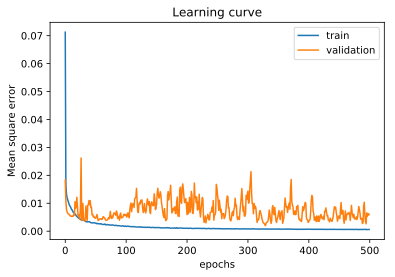

In [53]:
# Plotting the learning curve 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning curve')
plt.ylabel('Mean square error')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
# plt.savefig('/Figures/learning_curve_08Nov.png', bbox_inches='tight')

In [112]:
# Save trained model 
# serialize model to JSON
model_json = velModel.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
velModel.save_weights("velModel.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# Load saved model
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
velModel = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("velModel.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

velModel.compile(loss='mean_squared_error', metrics=['accuracy', 'mse'], optimizer = adam)


# To evaluate run the "Testing and evaluating the model" cell

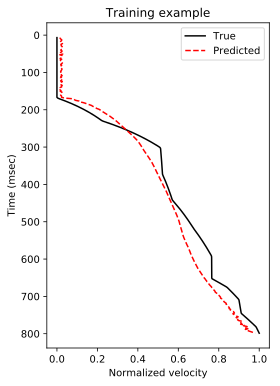

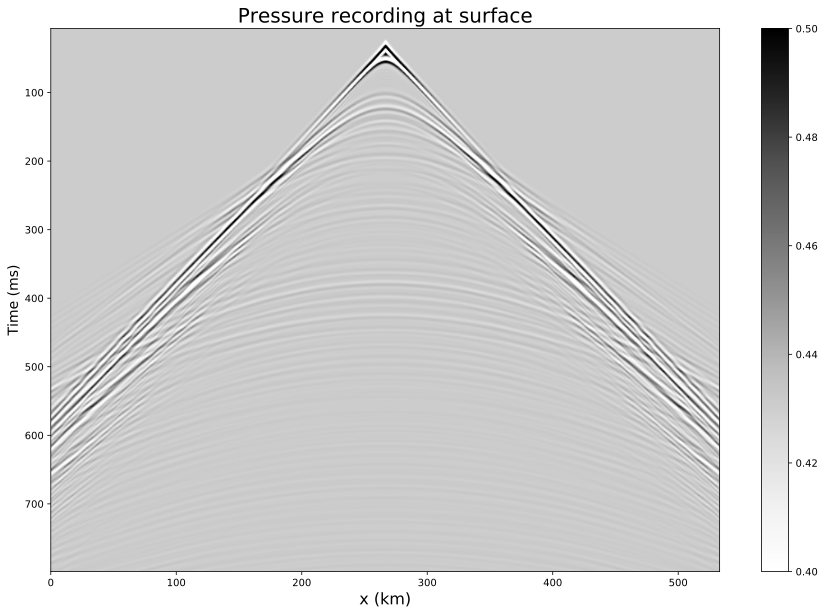

In [54]:
# Plot some of the training examples - true vs trained
sample_number = 30
X_train_sample = X_train[sample_number,:,:,:]
X_train_sample = np.expand_dims(X_train_sample, axis=0)
Y_train_sample = Y_train[sample_number,:]
Y_train_sample_predict = velModel.predict(X_train_sample)

figure(num=None, figsize=(4, 6), dpi=80, facecolor='w', edgecolor='k')
line1, = plt.plot(Y_train_sample, time_interp*1e3, '-k')
line2, = plt.plot(Y_train_sample_predict[0,:], time_interp*1e3, '--r')
plt.legend((line1, line2), ('True', 'Predicted'))
plt.xlabel('Normalized velocity')
plt.ylabel('Time (msec)')
plt.title('Training example')
plt.gca().invert_yaxis()
# plt.savefig('./Figures/training_example_velocity_08Dec.png', bbox_inches='tight')
plt.show()

# clip=0.65;
p_el = np.reshape(X_train[sample_number,:,:,:], (599,433)).transpose()
# vmin=np.min(p_el)*clip;
# vmax=np.max(p_el)*clip;
# fig, ax = plt.subplots(figsize=(10,10))
figure(figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(p_el[:,:], 
               interpolation='bilinear', 
               vmin=0.4, 
               vmax=0.5, 
               cmap=plt.get_cmap('Greys'), 
               aspect='auto',
               origin='upper', extent=[0,533,np.max(time_interp)*1e3,np.min(time_interp)*1e3])
plt.title('Pressure recording at surface', fontsize=20)
plt.xlabel('x (km)', fontsize=16)
plt.ylabel('Time (ms)', fontsize=14)
plt.colorbar()
plt.show()
# plt.savefig('./Figures/training_example_seismic_08Dec.png', bbox_inches='tight')

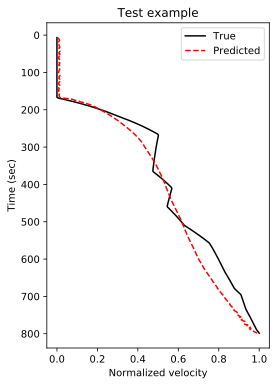

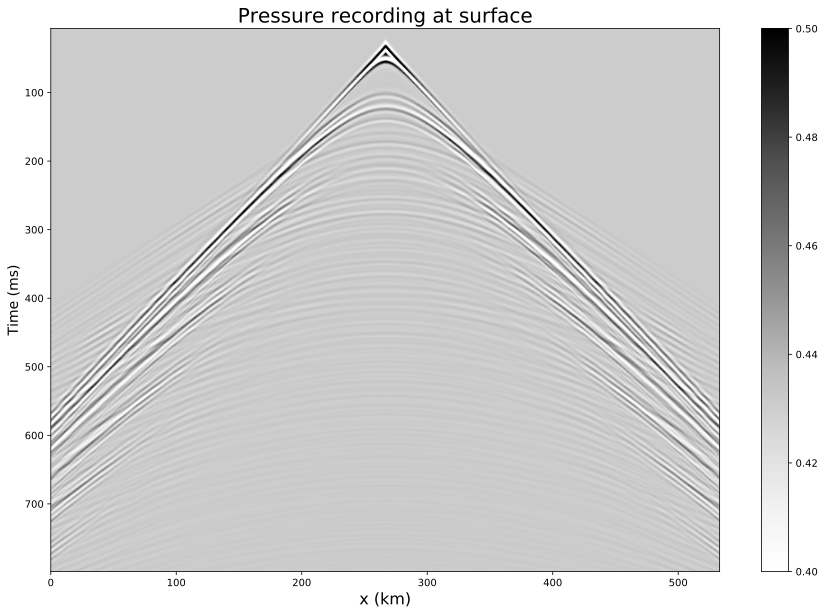

In [55]:
# Plot some of test examples
sample_number = 10 # 4, 40, 15, 25, 33
X_test_sample = X_test[sample_number,:,:,:]
X_test_sample = np.expand_dims(X_test_sample, axis=0)
Y_test_sample = Y_test[sample_number,:]
Y_test_sample_predict = velModel.predict(X_test_sample)

figure(num=None, figsize=(4, 6), dpi=80, facecolor='w', edgecolor='k')
line1, =plt.plot(Y_test_sample, time_interp*1e3, '-k')
line2, = plt.plot(Y_test_sample_predict[0,:], time_interp*1e3, '--r')
plt.legend((line1, line2), ('True', 'Predicted'))
plt.title('Test example')
plt.xlabel('Normalized velocity')
plt.ylabel('Time (sec)')
plt.gca().invert_yaxis()
# plt.savefig('Figures/test_example_velocity_08Dec_1.png', bbox_inches='tight')
plt.show()

# clip=0.65;
p_el = np.reshape(X_test[sample_number,:,:,:], (599,433)).transpose()
# vmin=np.min(p_el)*clip;
# vmax=np.max(p_el)*clip;
# fig, ax = plt.subplots(figsize=(10,10))
figure(figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(p_el[:,:], 
               interpolation='bilinear', 
               vmin=0.4, 
               vmax=0.5, 
               cmap=plt.get_cmap('Greys'), 
               aspect='auto',
               origin='upper', extent=[0,533,np.max(time_interp)*1e3,np.min(time_interp)*1e3])
plt.title('Pressure recording at surface', fontsize=20)
plt.xlabel('x (km)', fontsize=16)
plt.ylabel('Time (ms)', fontsize=14)
plt.colorbar()
plt.show()
# plt.savefig('Figures/test_example_seismic_08Dec_1.png', bbox_inches='tight')